In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.applications import ResNet50,EfficientNetB0
from keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import random
import cv2
from keras.layers import GlobalAveragePooling2D, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [16]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
data_path='Skin Disease/train'

In [18]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

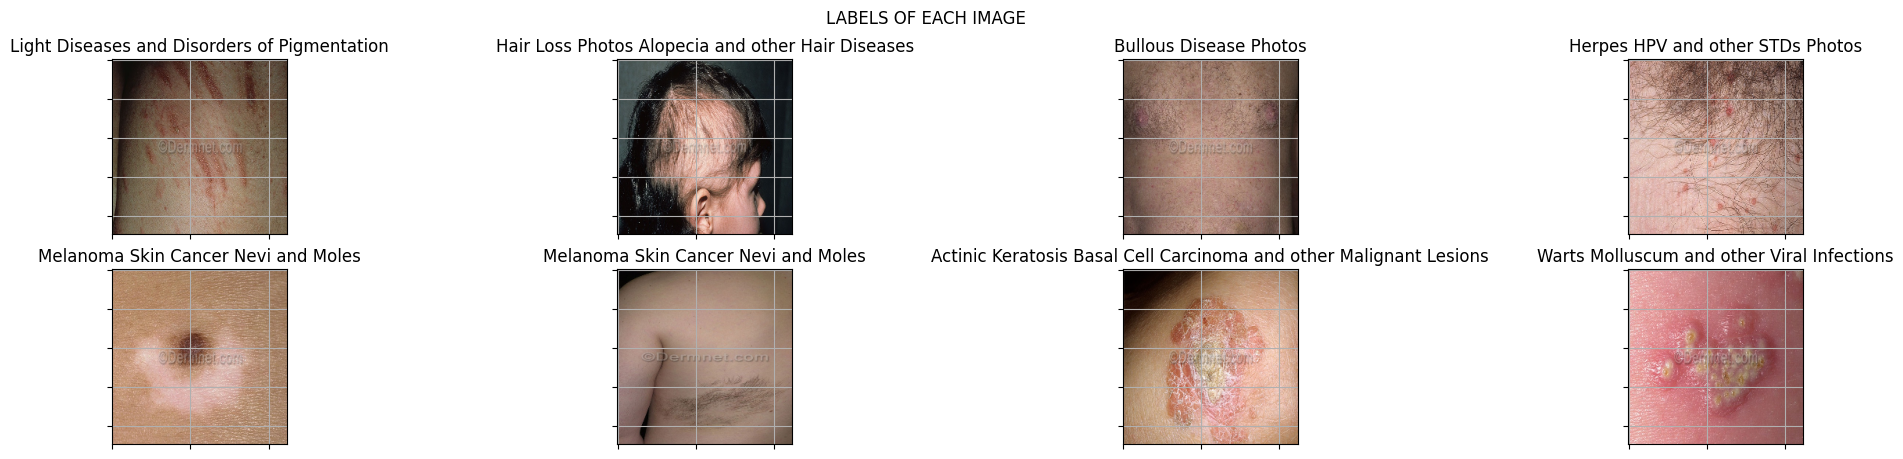

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(25, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [20]:
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, 23)
y_val_one_hot = to_categorical(y_val_encoded, 23)

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [22]:
num_classes = 23
image_resize = 224
EPOCHS=20
Batch_size=64
input_shape = (image_resize, image_resize, 3)

# Load ResNet50 and EfficientNetB0 without the top layers
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
efficientnet_base = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

# Create a common input layer
input_layer = keras.Input(shape=input_shape)

resnet_output = resnet_base(input_layer)
efficientnet_output = efficientnet_base(input_layer)
resnet_gap = layers.GlobalAveragePooling2D()(resnet_output)
efficientnet_gap = layers.GlobalAveragePooling2D()(efficientnet_output)

# Concatenate 
combined_output = layers.Concatenate()([resnet_gap, efficientnet_gap])

#Add Dropout
combined_output = layers.Dropout(0.5)(combined_output)  

# Add dense layers
dense_layer = layers.Dense(256, activation='relu')(combined_output)
output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
ensemble_model.fit(
    X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=Batch_size,callbacks=[custom_early_stopping]
)

# Print the model summary to check the structure
ensemble_model.summary()


Epoch 1/20
195/195 [==============================] - 3800s 19s/step - loss: 2.4102 - accuracy: 0.3078 - val_loss: 17.1394 - val_accuracy: 0.1773
Epoch 2/20
195/195 [==============================] - 3738s 19s/step - loss: 1.8380 - accuracy: 0.4522 - val_loss: 146.0827 - val_accuracy: 0.1132
Epoch 3/20
195/195 [==============================] - 3824s 20s/step - loss: 1.4814 - accuracy: 0.5576 - val_loss: 1.9314 - val_accuracy: 0.4566
Epoch 4/20
195/195 [==============================] - 3767s 19s/step - loss: 1.1840 - accuracy: 0.6400 - val_loss: 25.1383 - val_accuracy: 0.2443
Epoch 5/20
195/195 [==============================] - 3564s 18s/step - loss: 0.9321 - accuracy: 0.7123 - val_loss: 5.5241 - val_accuracy: 0.3543
Epoch 6/20
195/195 [==============================] - 3943s 20s/step - loss: 0.7293 - accuracy: 0.7728 - val_loss: 1.9769 - val_accuracy: 0.4941
Epoch 7/20
195/195 [==============================] - 3990s 20s/step - loss: 0.5674 - accuracy: 0.8179 - val_loss: 2.0995 - va

KeyboardInterrupt: 

In [ ]:
import history
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()